# About this notebook
- PyTorch tf_efficientnet_b7_ns starter code
- StratifiedKFold 5 folds
- Inference notebook is [here](https://www.kaggle.com/yasufuminakama/g2net-efficientnet-b0-baseline-inference)
- Spectrogram generation code
    - https://www.kaggle.com/yasufuminakama/g2net-n-mels-128-train-images is generated by https://www.kaggle.com/yasufuminakama/g2net-spectrogram-generation-train
    - https://www.kaggle.com/yasufuminakama/g2net-n-mels-128-test-images is generated by https://www.kaggle.com/yasufuminakama/g2net-spectrogram-generation-test
- version 2: melspectrogram approach using above dataset
- version 3: nnAudio Q-transform approach
    - Here is nnAudio Constant Q-transform Demonstration  
        - https://www.kaggle.com/atamazian/nnaudio-constant-q-transform-demonstration
        - https://www.kaggle.com/c/g2net-gravitational-wave-detection/discussion/250621
    - Thanks for sharing @atamazian  
- version 4: tf_efficientnet_b0_ns -> tf_efficientnet_b7_ns

If this notebook is helpful, feel free to upvote :)

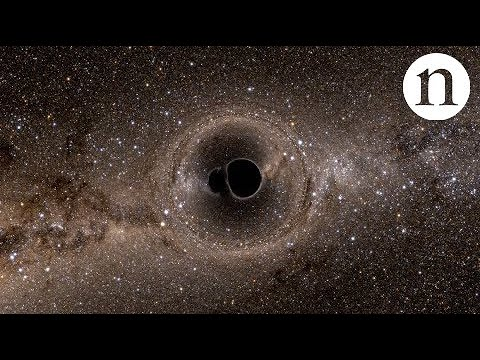

In [1]:
import IPython.display
IPython.display.YouTubeVideo('hhbMpe17fzA', width=800, height=500)

# Data Loading

In [2]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
train = pd.read_csv('../../dataset/training_labels.csv')
test = pd.read_csv('../../dataset/sample_submission.csv')

def get_train_file_path(image_id):
    return "../../dataset/train/{}/{}/{}/{}.npy".format(
        image_id[0], image_id[1], image_id[2], image_id)

def get_test_file_path(image_id):
    return "../../dataset/test/{}/{}/{}/{}.npy".format(
        image_id[0], image_id[1], image_id[2], image_id)

train['file_path'] = train['id'].apply(get_train_file_path)
test['file_path'] = test['id'].apply(get_test_file_path)

display(train.head())
display(test.head())

,id,target,file_path
0,00000e74ad,1,../../dataset/train/0/0/0/00000e74ad.npy
1,00001f4945,0,../../dataset/train/0/0/0/00001f4945.npy
2,0000661522,0,../../dataset/train/0/0/0/0000661522.npy
3,00007a006a,0,../../dataset/train/0/0/0/00007a006a.npy
4,0000a38978,1,../../dataset/train/0/0/0/0000a38978.npy


,id,target,file_path
0,00005bced6,0.5,../../dataset/test/0/0/0/00005bced6.npy
1,0000806717,0.5,../../dataset/test/0/0/0/0000806717.npy
2,0000ef4fe1,0.5,../../dataset/test/0/0/0/0000ef4fe1.npy
3,00020de251,0.5,../../dataset/test/0/0/0/00020de251.npy
4,00024887b5,0.5,../../dataset/test/0/0/0/00024887b5.npy


# Quick EDA

In [4]:
!pip install -q nnAudio

CQT kernels created, time used = 0.0185 seconds


/usr/local/lib/python3.7/dist-packages/nnAudio/utils.py:326: SyntaxWarning: If fmax is given, n_bins will be ignored
  warnings.warn('If fmax is given, n_bins will be ignored',SyntaxWarning)


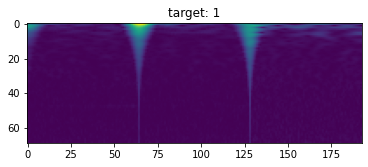

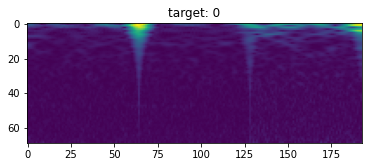

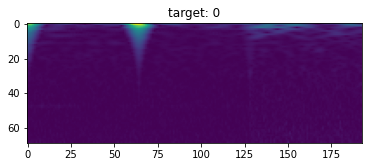

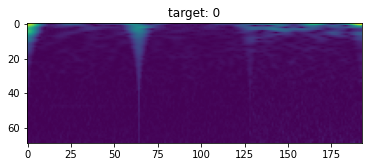

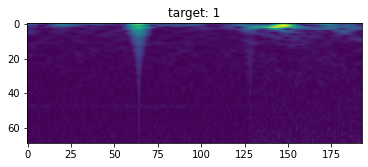

In [5]:
import torch
from nnAudio.Spectrogram import CQT1992v2

def apply_qtransform(waves, transform=CQT1992v2(sr=2048, fmin=20, fmax=1024, hop_length=64)):
    waves = np.hstack(waves)
    waves = waves / np.max(waves)
    waves = torch.from_numpy(waves).float()
    image = transform(waves)
    return image

for i in range(5):
    waves = np.load(train.loc[i, 'file_path'])
    image = apply_qtransform(waves)
    target = train.loc[i, 'target']
    plt.imshow(image[0])
    plt.title(f"target: {target}")
    plt.show()

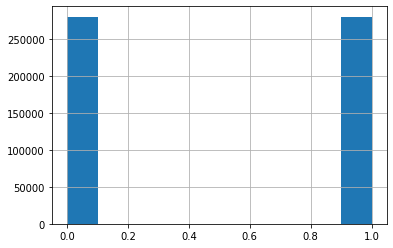

In [6]:
train['target'].hist()

# Directory settings

In [7]:
# ====================================================
# Directory settings
# ====================================================
import os

OUTPUT_DIR = '../../output/'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# CFG

In [8]:
# ====================================================
# CFG
# ====================================================
class CFG:
    apex=False
    debug=False
    print_freq=100
    num_workers=4
    model_name='tf_efficientnet_b7_ns'
    scheduler='CosineAnnealingLR' # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts']
    epochs=1
    #factor=0.2 # ReduceLROnPlateau
    #patience=4 # ReduceLROnPlateau
    #eps=1e-6 # ReduceLROnPlateau
    T_max=3 # CosineAnnealingLR
    #T_0=3 # CosineAnnealingWarmRestarts
    lr=1e-4
    min_lr=1e-6
    batch_size=64
    weight_decay=1e-6
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=42
    target_size=1
    target_col='target'
    n_fold=5
    trn_fold=[0] # [0, 1, 2, 3, 4]
    train=True
    
if CFG.debug:
    CFG.epochs = 1
    train = train.sample(n=50000, random_state=CFG.seed).reset_index(drop=True)

In [9]:
!pip uninstall albumentations -y
!pip install albumentations==0.5.2
!pip show albumentations

Found existing installation: albumentations 0.5.2
Uninstalling albumentations-0.5.2:
  Successfully uninstalled albumentations-0.5.2
  Using cached albumentations-0.5.2-py3-none-any.whl (72 kB)
Name: albumentations
Version: 0.5.2
Summary: Fast image augmentation library and easy to use wrapper around other libraries
Home-page: https://github.com/albumentations-team/albumentations
Author: Buslaev Alexander, Alexander Parinov, Vladimir Iglovikov, Eugene Khvedchenya, Druzhinin Mikhail
Author-email: None
License: MIT
Location: /usr/local/lib/python3.7/dist-packages
Requires: imgaug, numpy, PyYAML, opencv-python-headless, scikit-image, scipy
Required-by: 


In [10]:
# Library

In [11]:
# ====================================================
# Library
# ====================================================
import sys
sys.path.append('../../library/pytorch-image-models')

import os
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter

import scipy as sp
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

from tqdm.auto import tqdm
from functools import partial

import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

import timm

from torch.cuda.amp import autocast, GradScaler

# import warnings
# warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
# Utils

In [13]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = roc_auc_score(y_true, y_pred)
    return score


def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=CFG.seed)

# CV split

In [14]:
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(train, train[CFG.target_col])):
    train.loc[val_index, 'fold'] = int(n)
train['fold'] = train['fold'].astype(int)
display(train.groupby(['fold', 'target']).size())

fold  target
0     0         56014
      1         55986
1     0         56014
      1         55986
2     0         56014
      1         55986
3     0         56014
      1         55986
4     0         56014
      1         55986
dtype: int64

# Dataset

In [15]:
# ====================================================
# Dataset
# ====================================================
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['file_path'].values
        self.labels = df[CFG.target_col].values
        self.wave_transform = CQT1992v2(sr=2048, fmin=20, fmax=1024, hop_length=64)
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def apply_qtransform(self, waves, transform):
        waves = np.hstack(waves)
        waves = waves / np.max(waves)
        waves = torch.from_numpy(waves).float()
        image = transform(waves)
        return image

    def __getitem__(self, idx):
        file_path = self.file_names[idx]
        waves = np.load(file_path)
        image = self.apply_qtransform(waves, self.wave_transform)
        if self.transform:
            image = image.squeeze().numpy()
            image = self.transform(image=image)['image']
        label = torch.tensor(self.labels[idx]).float()
        return image, label

# Transforms

In [16]:
# ====================================================
# Transforms
# ====================================================
def get_transforms(*, data):
    
    if data == 'train':
        return A.Compose([
            ToTensorV2(),
        ])

    elif data == 'valid':
        return A.Compose([
            ToTensorV2(),
        ])

In [17]:
train

,id,target,file_path,fold
0,00000e74ad,1,../../dataset/train/0/0/0/00000e74ad.npy,2
1,00001f4945,0,../../dataset/train/0/0/0/00001f4945.npy,1
2,0000661522,0,../../dataset/train/0/0/0/0000661522.npy,3
3,00007a006a,0,../../dataset/train/0/0/0/00007a006a.npy,3
4,0000a38978,1,../../dataset/train/0/0/0/0000a38978.npy,4
...,...,...,...,...
559995,ffff9a5645,1,../../dataset/train/f/f/f/ffff9a5645.npy,2
559996,ffffab0c27,0,../../dataset/train/f/f/f/ffffab0c27.npy,2
559997,ffffcf161a,1,../../dataset/train/f/f/f/ffffcf161a.npy,2
559998,ffffd2c403,0,../../dataset/train/f/f/f/ffffd2c403.npy,4


CQT kernels created, time used = 0.0285 seconds


/usr/local/lib/python3.7/dist-packages/nnAudio/utils.py:326: SyntaxWarning: If fmax is given, n_bins will be ignored
  warnings.warn('If fmax is given, n_bins will be ignored',SyntaxWarning)


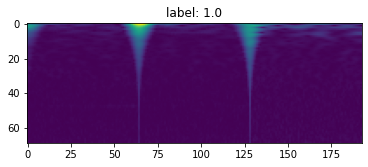

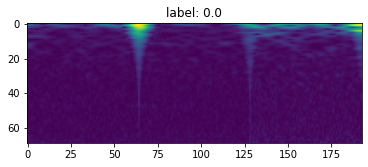

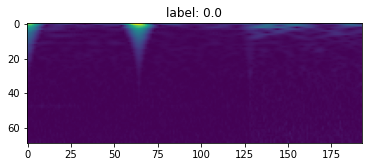

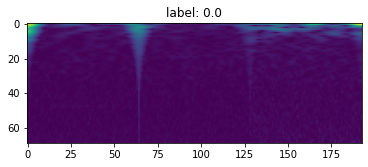

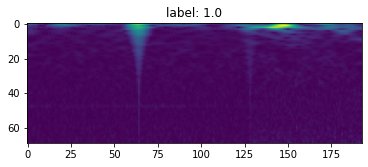

In [18]:
train_dataset = TrainDataset(train, transform=get_transforms(data='train'))

for i in range(5):
    image, label = train_dataset[i]
    plt.imshow(image[0])
    plt.title(f'label: {label}')
    plt.show()

# MODEL

In [19]:
# ====================================================
# MODEL
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, cfg, pretrained=False):
        super().__init__()
        self.cfg = cfg
        self.model = timm.create_model(self.cfg.model_name, pretrained=pretrained, in_chans=1)
        self.n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(self.n_features, self.cfg.target_size)

    def forward(self, x):
        output = self.model(x)
        return output

# Helper functions

In [20]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    if CFG.apex:
        scaler = GradScaler()
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        if CFG.apex:
            with autocast():
                y_preds = model(images)
                loss = criterion(y_preds.view(-1), labels)
        else:
            y_preds = model(images)
            loss = criterion(y_preds.view(-1), labels)
        # record loss
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        if CFG.apex:
            scaler.scale(loss).backward()
        else:
            loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            if CFG.apex:
                scaler.step(optimizer)
                scaler.update()
            else:
                optimizer.step()
            optimizer.zero_grad()
            global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  #'LR: {lr:.6f}  '
                  .format(
                   epoch+1, step, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(train_loader)),
                   grad_norm=grad_norm,
                   #lr=scheduler.get_lr()[0],
                   ))
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        loss = criterion(y_preds.view(-1), labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(
                   step, len(valid_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(valid_loader)),
                   ))
    predictions = np.concatenate(preds)
    return losses.avg, predictions

# Train loop

In [21]:
# ====================================================
# Train loop
# ====================================================
def train_loop(folds, fold):
    
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index

    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)
    valid_labels = valid_folds[CFG.target_col].values

    train_dataset = TrainDataset(train_folds, transform=get_transforms(data='train'))
    valid_dataset = TrainDataset(valid_folds, transform=get_transforms(data='train'))

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size, 
                              shuffle=True, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, 
                              batch_size=CFG.batch_size * 2, 
                              shuffle=False, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    
    # ====================================================
    # scheduler 
    # ====================================================
    def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
        elif CFG.scheduler=='CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG, pretrained=True)
    model.to(device)

    optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, amsgrad=False)
    scheduler = get_scheduler(optimizer)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.BCEWithLogitsLoss()

    best_score = 0.
    best_loss = np.inf
    
    for epoch in range(CFG.epochs):
        
        start_time = time.time()
        
        # train
        avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()

        # scoring
        score = get_score(valid_labels, preds)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')

        if score > best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(), 
                        'preds': preds},
                        OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best_score.pth')
        
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            LOGGER.info(f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
            torch.save({'model': model.state_dict(), 
                        'preds': preds},
                        OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best_loss.pth')
    
    valid_folds['preds'] = torch.load(OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best_score.pth', 
                                      map_location=torch.device('cpu'))['preds']

    return valid_folds

In [22]:
# ====================================================
# main
# ====================================================
def main():

    """
    Prepare: 1.train 
    """

    def get_result(result_df):
        preds = result_df['preds'].values
        labels = result_df[CFG.target_col].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    if CFG.train:
        # train 
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(train, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        # CV result
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        # save result
        oof_df.to_csv(OUTPUT_DIR+'oof_df.csv', index=False)

In [27]:
if __name__ == '__main__':
    main()

========== fold: 0 training ==========


CQT kernels created, time used = 0.0222 seconds
CQT kernels created, time used = 0.0180 seconds


/usr/local/lib/python3.7/dist-packages/nnAudio/utils.py:326: SyntaxWarning: If fmax is given, n_bins will be ignored
  warnings.warn('If fmax is given, n_bins will be ignored',SyntaxWarning)


Epoch: [1][0/7000] Data 12.524 (12.524) Elapsed 0m 13s (remain 1616m 53s) Loss: 0.7108(0.7108) Grad: 2.5585  
Epoch: [1][100/7000] Data 0.000 (2.252) Elapsed 5m 56s (remain 406m 22s) Loss: 0.4818(0.6308) Grad: 1.9886  
Epoch: [1][200/7000] Data 0.000 (2.265) Elapsed 10m 52s (remain 367m 39s) Loss: 0.5764(0.5898) Grad: 1.4746  
Epoch: [1][300/7000] Data 0.000 (2.262) Elapsed 15m 44s (remain 350m 30s) Loss: 0.5072(0.5663) Grad: 1.5481  
Epoch: [1][400/7000] Data 0.000 (2.226) Elapsed 20m 24s (remain 335m 47s) Loss: 0.4927(0.5535) Grad: 1.3756  
Epoch: [1][500/7000] Data 0.000 (2.205) Elapsed 25m 3s (remain 325m 5s) Loss: 0.5194(0.5426) Grad: 0.8553  


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f989506ae60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f989506ae60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch: [1][600/7000] Data 0.000 (2.198) Elapsed 29m 47s (remain 317m 12s) Loss: 0.4488(0.5363) Grad: 0.8133  
Epoch: [1][700/7000] Data 9.472 (2.260) Elapsed 35m 18s (remain 317m 14s) Loss: 0.4919(0.5292) Grad: 0.8944  
Epoch: [1][800/7000] Data 0.000 (2.254) Elapsed 40m 6s (remain 310m 26s) Loss: 0.5493(0.5225) Grad: 0.8110  
Epoch: [1][900/7000] Data 0.000 (2.254) Elapsed 44m 59s (remain 304m 31s) Loss: 0.4345(0.5179) Grad: 0.7953  
Epoch: [1][1000/7000] Data 0.000 (2.245) Elapsed 49m 43s (remain 297m 57s) Loss: 0.4496(0.5139) Grad: 0.9957  
Epoch: [1][1100/7000] Data 5.765 (2.236) Elapsed 54m 25s (remain 291m 35s) Loss: 0.4377(0.5103) Grad: 0.5646  
Epoch: [1][1200/7000] Data 8.540 (2.276) Elapsed 60m 4s (remain 290m 5s) Loss: 0.5573(0.5074) Grad: 0.9794  
Epoch: [1][1300/7000] Data 7.164 (2.275) Elapsed 64m 58s (remain 284m 38s) Loss: 0.5385(0.5050) Grad: 0.9976  
Epoch: [1][1400/7000] Data 0.000 (2.272) Elapsed 69m 48s (remain 279m 0s) Loss: 0.5190(0.5035) Grad: 0.8457  
Epoch: [1

Epoch 1 - avg_train_loss: 0.4648  avg_val_loss: 0.4603  time: 31419s
Epoch 1 - Score: 0.8522
Epoch 1 - Save Best Score: 0.8522 Model


EVAL: [874/875] Data 20.053 (7.588) Elapsed 114m 46s (remain 0m 0s) Loss: 0.4040(0.4603) 


Epoch 1 - Save Best Loss: 0.4603 Model
========== fold: 0 result ==========
Score: 0.8522
========== CV ==========
Score: 0.8522


In [ ]:
from glob import glob
glob("../../dataset/train/*/2cc2784c13.*", recursive="True")

[]